In [64]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
import matplotlib.pyplot as plt
from itertools import combinations

In [129]:
# 第一步：获取数据并计算基本特征
def initial_preprocessing():
    # 获取SP500数据
    sp500_data = yf.Ticker("^GSPC")
    sp500_data = sp500_data.history(period="max")
    
    # 计算日度收益率
    sp500_data['Daily_Return'] = sp500_data['Close'].pct_change().dropna()
    
    # 创建滞后收益率特征
    for lag in range(1, 22):  # 1到21日的滞后收益率
        sp500_data[f'Lagged_Return_{lag}'] = sp500_data['Daily_Return'].shift(lag)
    
    # 计算移动平均值特征
    sp500_data['MA_5'] = sp500_data['Close'].rolling(window=5).mean()
    sp500_data['MA_10'] = sp500_data['Close'].rolling(window=10).mean()
    sp500_data['MA_20'] = sp500_data['Close'].rolling(window=20).mean()
    sp500_data['MA_50'] = sp500_data['Close'].rolling(window=50).mean()
    sp500_data['MA_100'] = sp500_data['Close'].rolling(window=100).mean()
    
    # 计算移动标准差特征
    sp500_data['STD_5'] = sp500_data['Close'].rolling(window=5).std()
    sp500_data['STD_10'] = sp500_data['Close'].rolling(window=10).std()
    sp500_data['STD_20'] = sp500_data['Close'].rolling(window=20).std()
    sp500_data['STD_50'] = sp500_data['Close'].rolling(window=50).std()
    sp500_data['STD_100'] = sp500_data['Close'].rolling(window=100).std()
    
    # 计算技术指标（RSI）
    def calculate_RSI(series, period=14):
        delta = series.diff(1)
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        RS = gain / loss
        RSI = 100 - (100 / (1 + RS))
        return RSI

    sp500_data['RSI_14'] = calculate_RSI(sp500_data['Close'], period=14)
    sp500_data['RSI_28'] = calculate_RSI(sp500_data['Close'], period=28)
    sp500_data['RSI_42'] = calculate_RSI(sp500_data['Close'], period=42)
    sp500_data['RSI_56'] = calculate_RSI(sp500_data['Close'], period=56)
    sp500_data['RSI_70'] = calculate_RSI(sp500_data['Close'], period=70)
    
    # 计算动量因子
    sp500_data['Momentum_10'] = sp500_data['Close'] / sp500_data['Close'].shift(10) - 1
    sp500_data['Momentum_20'] = sp500_data['Close'] / sp500_data['Close'].shift(20) - 1
    sp500_data['Momentum_60'] = sp500_data['Close'] / sp500_data['Close'].shift(60) - 1
    
    # 扩充成交量特征
    sp500_data['Volume_MA_5'] = sp500_data['Volume'].rolling(window=5).mean()
    sp500_data['Volume_MA_10'] = sp500_data['Volume'].rolling(window=10).mean()
    sp500_data['Volume_MA_20'] = sp500_data['Volume'].rolling(window=20).mean()
    sp500_data['Volume_MA_50'] = sp500_data['Volume'].rolling(window=50).mean()
    
    # 计算价格比率特征
    sp500_data['Open_Close_Ratio'] = sp500_data['Open'] / sp500_data['Close']
    sp500_data['High_Low_Ratio'] = sp500_data['High'] / sp500_data['Low']
    
    # 创建季节性效应特征
    sp500_data['Month'] = sp500_data.index.month  # 当前月
    sp500_data['Quarter'] = sp500_data.index.quarter  # 当前季度
    sp500_data['Day_of_Week'] = sp500_data.index.dayofweek  # 当前星期几
    
    # 去除包含NaN值的行
    sp500_data.dropna(inplace=True)
    
    return sp500_data

# 第二步：高级特征工程
def create_advanced_features(df):
    # 动量因子与移动平均值的组合
    df['Momentum_10_MA_5'] = df['Momentum_10'] / df['MA_5']
    df['Momentum_20_MA_10'] = df['Momentum_20'] / df['MA_10']
    df['Momentum_60_MA_20'] = df['Momentum_60'] / df['MA_20']

    # RSI与移动标准差的组合
    df['RSI_14_STD_20'] = df['RSI_14'] / df['STD_20']
    df['RSI_28_STD_50'] = df['RSI_28'] / df['STD_50']
    df['RSI_42_STD_100'] = df['RSI_42'] / df['STD_100']

    # 移动平均值与标准差的组合
    df['MA_5_over_STD_5'] = df['MA_5'] / df['STD_5']
    df['MA_10_over_STD_10'] = df['MA_10'] / df['STD_10']
    df['MA_20_over_STD_20'] = df['MA_20'] / df['STD_20']

    # 不同移动平均值的比率组合
    df['MA_5_over_MA_20'] = df['MA_5'] / df['MA_20']
    df['MA_10_over_MA_50'] = df['MA_10'] / df['MA_50']
    df['MA_20_over_MA_100'] = df['MA_20'] / df['MA_100']

    # 创建滞后收益率的组合
    for (lag1, lag2) in combinations(['Lagged_Return_1', 'Lagged_Return_5', 'Lagged_Return_10', 'Lagged_Return_21'], 2):
        df[f'{lag1}_minus_{lag2}'] = df[lag1] - df[lag2]
        df[f'{lag1}_times_{lag2}'] = df[lag1] * df[lag2]

    # 季节性效应特征与价格组合
    df['Month_times_Close'] = df['Month'] * df['Close']
    df['Quarter_times_Open'] = df['Quarter'] * df['Open']
    df['Day_of_Week_times_High'] = df['Day_of_Week'] * df['High']

    return df

# 应用特征工程生成数据
data = initial_preprocessing()
data = create_advanced_features(data)

# 数据集划分为训练集、CV集和测试集
features = data.columns.drop(['Daily_Return'])
X = data[features]
y = data['Daily_Return']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=False)    # 时间序列不用shuffle乱序
X_cv, X_test, y_cv, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# 保存列名
X_train_df = X_train.copy()

# 数据标准化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_cv = scaler.transform(X_cv)
X_test = scaler.transform(X_test)

# 将标准化后的数据转换回DataFrame，并保留原始列名
X_train = pd.DataFrame(X_train, columns=X_train_df.columns, index=X_train_df.index)
X_cv = pd.DataFrame(X_cv, columns=X_train_df.columns, index=X_temp.index[:len(X_cv)])
X_test = pd.DataFrame(X_test, columns=X_train_df.columns, index=X_temp.index[len(X_cv):])

print("Final Data Preparation Completed.\n")

Final Data Preparation Completed.



In [147]:
# 第二步：线性回归模型
print("Step 2: Linear Regression...")

# 使用线性回归模型进行交叉验证
lr_model = LinearRegression()
kf = KFold(n_splits=5, shuffle=False)
lr_cv_mse = -cross_val_score(lr_model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')

# 使用 statsmodels 进行回归分析以获得显著性检验结果
X_train_with_const = sm.add_constant(X_train)  # 添加常数项
lr_sm_model = sm.OLS(y_train, X_train_with_const).fit()

# 进行模型训练与测试预测
lr_model.fit(X_train, y_train)
lr_test_pred = lr_model.predict(X_test)

# 显示模型性能
results_lr = {
    'CV MSE Mean': lr_cv_mse.mean(),
    'CV MSE Std': lr_cv_mse.std(),
    'Test MSE': mean_squared_error(y_test, lr_test_pred)
}

print("Linear Regression Results:")
for metric_name, value in results_lr.items():
    print(f"  {metric_name}: {value}")

print("Linear Regression Completed.\n")

# 提取回归系数并替换名称
coefficients = lr_model.coef_
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
})

# 如果有截距项，也可以加上截距
intercept = lr_model.intercept_
coef_df.loc[-1] = ['Intercept', intercept]
coef_df.index = coef_df.index + 1  # 重新排序
coef_df.sort_index(inplace=True)

# 输出结果
print("Significance Test Results (OLS):")
print(lr_sm_model.summary())
print("\nLinear Regression Coefficients:")
print(coef_df)

# 保存为 Excel 文件
coef_df.to_excel("Linear_Regression_Coefficients.xlsx", index=False)

# 如果你需要将结果保存为 CSV 文件
coef_df.to_csv("Linear_Regression_Coefficients.csv", index=False)

# 直接输出为可以复制到Word文档的表格格式
print("\nCoefficients Table (for Word):")
print(coef_df.to_string(index=False))

# 保存回归结果为文本文件
with open("Linear_Regression_Summary.txt", "w") as f:
    f.write(lr_sm_model.summary().as_text())

print("Results saved to files.")


Step 2: Linear Regression...
Linear Regression Results:
  CV MSE Mean: 6.358613840533218e-06
  CV MSE Std: 9.121503618716382e-06
  Test MSE: 0.0017569783865755007
Linear Regression Completed.

Significance Test Results (OLS):
                            OLS Regression Results                            
Dep. Variable:           Daily_Return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     9750.
Date:                Tue, 27 Aug 2024   Prob (F-statistic):               0.00
Time:                        19:23:22   Log-Likelihood:                 71863.
No. Observations:               14508   AIC:                        -1.436e+05
Df Residuals:                   14433   BIC:                        -1.430e+05
Df Model:                          74                                         
Covariance Type:            nonrobust                          

In [149]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import numpy as np

# 假设initial_preprocessing和create_advanced_features已经完成

# 第三步：自动剔除不显著特征并返回线性回归结果
def automatic_feature_selection(X, y, significance_level=0.05):
    remaining_features = X.columns.tolist()
    p_max = 1  # 初始p值设为1
    while p_max > significance_level:
        X_with_const = sm.add_constant(X[remaining_features])  # 添加常数项
        lr_sm_model = sm.OLS(y, X_with_const).fit()
        p_values = lr_sm_model.pvalues[1:]  # 跳过常数项的p值
        p_max = max(p_values)
        if p_max > significance_level:
            excluded_feature = p_values.idxmax()  # 获取p值最大的特征
            remaining_features.remove(excluded_feature)
            print(f"Excluding feature '{excluded_feature}' with p-value {p_max:.4f}")
    
    print("\nFinal selected features:")
    print(remaining_features)
    
    # 最终模型
    X_final = sm.add_constant(X[remaining_features])
    final_model = sm.OLS(y, X_final).fit()
    
    return final_model, remaining_features

# 执行自动特征选择
final_model, selected_features = automatic_feature_selection(X_train, y_train)

# 对最终模型进行测试
X_test_selected = sm.add_constant(X_test[selected_features])
test_predictions = final_model.predict(X_test_selected)

# 显示最终模型性能
final_test_mse = mean_squared_error(y_test, test_predictions)
print("\nFinal Test MSE:", final_test_mse)

# 输出回归结果
print("\nFinal Model Summary:")
print(final_model.summary())

# 输出选择的特征及其系数
final_coef_df = pd.DataFrame({
    'Feature': ['Intercept'] + selected_features,
    'Coefficient': final_model.params
})

print("\nFinal Model Coefficients:")
print(final_coef_df)

# 保存最终选择的特征和系数为Excel文件
final_coef_df.to_excel("Final_Model_Coefficients.xlsx", index=False)

# 直接输出为可以复制到Word文档的表格格式
print("\nCoefficients Table (for Word):")
print(final_coef_df.to_string(index=False))

# 保存最终模型回归结果为文本文件
with open("Final_Model_Summary.txt", "w") as f:
    f.write(final_model.summary().as_text())

print("Results saved to files.")


Excluding feature 'RSI_28_STD_50' with p-value 0.8991
Excluding feature 'MA_5_over_STD_5' with p-value 0.8768
Excluding feature 'Lagged_Return_1_times_Lagged_Return_21' with p-value 0.8637
Excluding feature 'RSI_42_STD_100' with p-value 0.8528
Excluding feature 'Dividends' with p-value 0.8995
Excluding feature 'High_Low_Ratio' with p-value 0.7843
Excluding feature 'Volume_MA_20' with p-value 0.6600
Excluding feature 'Stock Splits' with p-value 0.8748
Excluding feature 'MA_100' with p-value 0.6707
Excluding feature 'Month_times_Close' with p-value 0.4992
Excluding feature 'Day_of_Week_times_High' with p-value 0.4879
Excluding feature 'Quarter_times_Open' with p-value 0.4813
Excluding feature 'Lagged_Return_5_times_Lagged_Return_21' with p-value 0.3209
Excluding feature 'RSI_28' with p-value 0.3104
Excluding feature 'Open' with p-value 0.2732
Excluding feature 'Lagged_Return_5_times_Lagged_Return_10' with p-value 0.2436
Excluding feature 'MA_20' with p-value 0.2103
Excluding feature 'MA_

In [143]:
# Ridge回归模型
print("Step 3: Ridge Regression...")

alpha_values = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
ridge_results = []

best_alpha = None
best_test_mse = float('inf')
best_result = None

for alpha in alpha_values:
    ridge_model = Ridge(alpha=alpha)
    
    # 交叉验证获取训练MSE
    ridge_cv_mse = -cross_val_score(ridge_model, X_train, y_train, cv=KFold(n_splits=5, shuffle=False), scoring='neg_mean_squared_error')
    ridge_mse_mean = ridge_cv_mse.mean()
    ridge_mse_std = ridge_cv_mse.std()
    
    # 训练模型并获取测试MSE
    ridge_model.fit(X_train, y_train)
    ridge_test_pred = ridge_model.predict(X_test)
    ridge_test_mse = mean_squared_error(y_test, ridge_test_pred)
    
    # 存储结果
    result = {
        'Alpha': alpha,
        'Avg Train MSE': ridge_mse_mean,
        'CV MSE Std': ridge_mse_std,
        'Test MSE': ridge_test_mse
    }
    ridge_results.append(result)
    
    # 更新最佳结果
    if ridge_test_mse < best_test_mse:
        best_test_mse = ridge_test_mse
        best_alpha = alpha
        best_result = result

# 创建 DataFrame
df_ridge = pd.DataFrame(ridge_results)

# 将 DataFrame 保存为 Excel 文件
df_ridge.to_excel("Ridge_Regression_Results.xlsx", index=False)

# 或者保存为 CSV 文件
df_ridge.to_csv("Ridge_Regression_Results.csv", index=False)

# 打印表格，可以直接复制粘贴到 Word 文档中
print("Ridge Regression Results:")
print(df_ridge.to_string(index=False))

# 强调最优结果
print("\nBest Ridge Regression Model:")
for key, value in best_result.items():
    print(f"{key}: {value:.6f}")

print("Ridge Regression Completed.\n")


Step 3: Ridge Regression...
Ridge Regression Results:
  Alpha  Avg Train MSE  CV MSE Std  Test MSE
   0.01       0.000006    0.000009  0.001745
   0.10       0.000006    0.000009  0.001695
   1.00       0.000006    0.000010  0.001554
  10.00       0.000007    0.000011  0.001713
 100.00       0.000012    0.000017  0.002039
1000.00       0.000066    0.000089  0.002388

Best Ridge Regression Model:
Alpha: 1.000000
Avg Train MSE: 0.000006
CV MSE Std: 0.000010
Test MSE: 0.001554
Ridge Regression Completed.



Fitting 5 folds for each of 81 candidates, totalling 405 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
135 fits failed out of a total of 405.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
62 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/anaconda3/lib/python3.12/site-pa

Test MSE: 8.3915747623138e-05
Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Feature Importances:
             Feature  Importance
43       Momentum_10    0.065159
61   MA_5_over_STD_5    0.052206
64   MA_5_over_MA_20    0.050475
55  Momentum_10_MA_5    0.040676
38            RSI_14    0.030272
..               ...         ...
47      Volume_MA_10    0.001128
48      Volume_MA_20    0.001092
49      Volume_MA_50    0.001039
6       Stock Splits    0.000000
5          Dividends    0.000000

[82 rows x 2 columns]


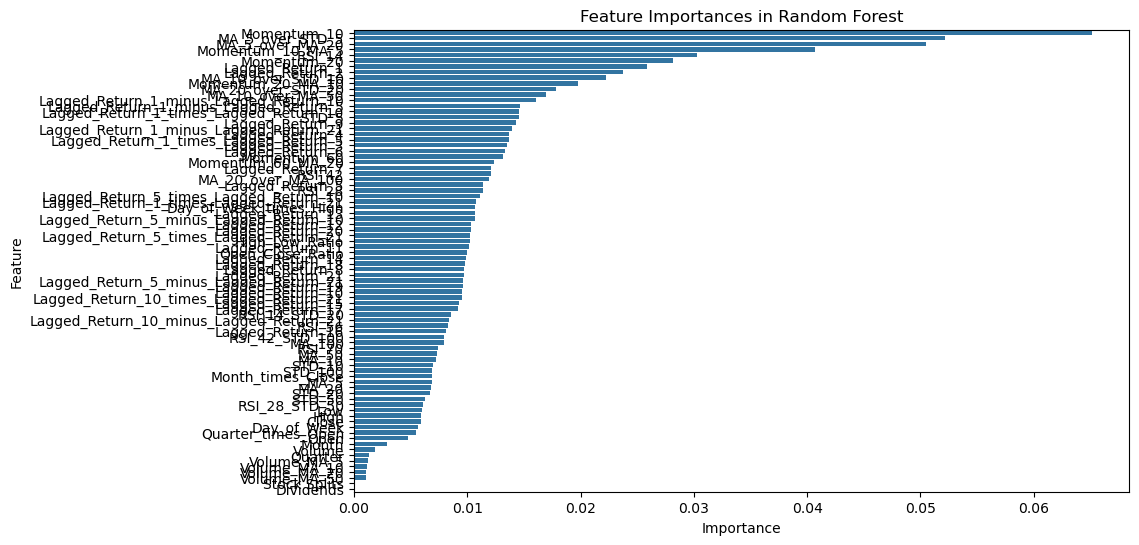

In [75]:
# 定义参数搜索空间
param_grid = {
    'n_estimators': [300],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# 初始化随机森林模型
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

# 使用GridSearchCV进行参数优化
grid_search = GridSearchCV(
    estimator=rf_model, 
    param_grid=param_grid, 
    cv=5,  # 5折交叉验证
    scoring='neg_mean_squared_error',  # 评价指标：负均方误差
    n_jobs=-1,  # 并行计算
    verbose=2  # 输出详细信息
)

# 拟合模型
grid_search.fit(X_train, y_train)

# 提取最佳模型
best_rf_model = grid_search.best_estimator_

# 使用最佳模型进行预测
rf_test_pred = best_rf_model.predict(X_test)

# 评估模型
test_mse = mean_squared_error(y_test, rf_test_pred)
print(f"Test MSE: {test_mse}")
print("Best Parameters:", grid_search.best_params_)

# 计算特征重要性
feature_importances = best_rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,  # 假设 features 是你的特征名列表
    'Importance': feature_importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 显示特征重要性结果
print("Feature Importances:")
print(feature_importance_df)

# 可视化特征重要性
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances in Random Forest')
plt.show()


Fitting 5 folds for each of 81 candidates, totalling 405 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
135 fits failed out of a total of 405.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
58 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/anaconda3/lib/python3.12/site-pa

Parameter Combinations and Their Test MSE:
    max_depth max_features  min_samples_leaf  min_samples_split  n_estimators  \
0           5         auto                 1                  2           300   
1           5         auto                 1                  5           300   
2           5         auto                 1                 10           300   
3           5         auto                 2                  2           300   
4           5         auto                 2                  5           300   
..        ...          ...               ...                ...           ...   
76         20         log2                 2                  5           300   
77         20         log2                 2                 10           300   
78         20         log2                 4                  2           300   
79         20         log2                 4                  5           300   
80         20         log2                 4                 10   

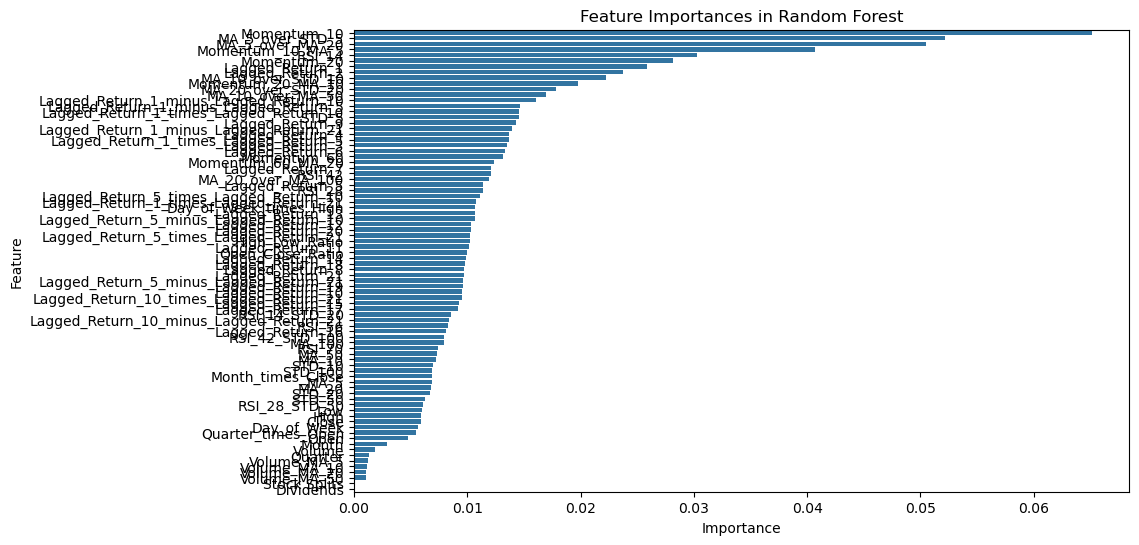

In [151]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

def random_forest_with_hyperparameter_tuning(X_train, y_train, X_test, y_test, features):
    # 定义参数搜索空间
    param_grid = {
        'n_estimators': [300],
        'max_depth': [5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    }

    # 初始化随机森林模型
    rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

    # 使用GridSearchCV进行参数优化
    grid_search = GridSearchCV(
        estimator=rf_model, 
        param_grid=param_grid, 
        cv=5,  # 5折交叉验证
        scoring='neg_mean_squared_error',  # 评价指标：负均方误差
        n_jobs=-1,  # 并行计算
        verbose=2  # 输出详细信息
    )

    # 拟合模型
    grid_search.fit(X_train, y_train)

    # 提取所有参数组合的结果
    results = grid_search.cv_results_
    params = results['params']
    mean_test_scores = results['mean_test_score']

    # 创建包含所有参数组合及其测试集MSE的表格
    results_df = pd.DataFrame(params)
    results_df['Test MSE'] = [-score for score in mean_test_scores]  # 由于分数是负的，所以转为正的MSE

    # 保存表格到文件
    results_df.to_excel("Random_Forest_Parameter_Grid_Results.xlsx", index=False)

    # 输出表格
    print("Parameter Combinations and Their Test MSE:")
    print(results_df)

    # 提取最佳模型
    best_rf_model = grid_search.best_estimator_

    # 使用最佳模型进行预测
    rf_test_pred = best_rf_model.predict(X_test)

    # 评估模型
    test_mse = mean_squared_error(y_test, rf_test_pred)
    print(f"Test MSE for Best Model: {test_mse}")
    print("Best Parameters:", grid_search.best_params_)

    # 计算特征重要性
    feature_importances = best_rf_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': features,  # 假设 features 是你的特征名列表
        'Importance': feature_importances
    })
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # 显示特征重要性结果
    print("Feature Importances:")
    print(feature_importance_df)

    # 可视化特征重要性
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title('Feature Importances in Random Forest')
    plt.show()

    # 返回结果表格和最佳模型
    return results_df, best_rf_model

# 使用这个函数
results_df, best_rf_model = random_forest_with_hyperparameter_tuning(X_train, y_train, X_test, y_test, features)


Step 5: Plotting Results...


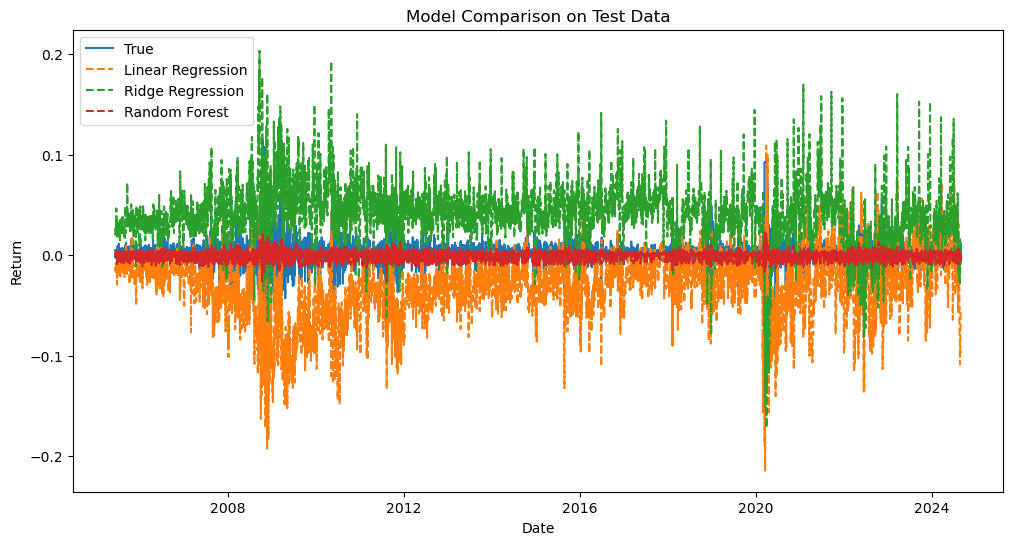

Plotting Completed.


In [153]:
# 可视化模型预测结果
print("Step 5: Plotting Results...")

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='True')
plt.plot(y_test.index, lr_test_pred, label='Linear Regression', linestyle='--')
plt.plot(y_test.index, ridge_test_pred, label='Ridge Regression', linestyle='--')
plt.plot(y_test.index, rf_test_pred, label='Random Forest', linestyle='--')
plt.title('Model Comparison on Test Data')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.show()

print("Plotting Completed.")